# Etivity 3 - Task 1: Classification
## Name: Brian Mortimer
## Student ID: 20258763

Open a new Jupyter notebook and name it etivity3_classification.ipynb. In this notebook, first of all, replace the column `insurance_cost` with a binary column `insurance_cost_binary`, where `insurance_cost_binary` is 0 if the corresponding `insurance_cost` is less than or equal to the median insurance cost and 1 otherwise. Then train three classification pipelines with SVM, Random Forest and a third classifier of your choice as the final estimator, respectively, to train a model that predicts the value of `insurance_cost_binary`. 

Requirements:
- For each classifier, include data preparation and dimensionality reduction steps in the main pipeline.
- You can choose any classifier as the third one. Some options are MLPClassifier, Naive Bayes, and kNN, but you are not limited to them.
- For the dimensionality reduction step use PCA, RFE and a third dimensionality reduction (incl. feature selection) technique in at least one pipeline.
- Use grid search for hyperparameter tuning and replicate the process in the example notebook Tutorial 3-1 - Binary Classification.ipynb to evaluate and compare the models you have trained and pick the best one.
- Summarise your experience in a markdown cell (max 150 words in a markdown cell).

In [20]:
# Imports
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import matplotlib.pyplot as plt
%matplotlib inline



In [21]:
# Functions
def load_insurance_data():
    """
    Load the insurance dataset from a CSV file.
    Convert the 'insurance_cost' column to binary values based on the median.
    The binary values are defined as follows:
    0 = less than or equal to median,
    1 = greater than median.

    Returns DataFrame.
    """
    # Load the dataset
    df = pd.read_csv('insurance.csv')

    # Convert 'insurance_cost' to binary values
    # 0 = less than or equal to median,
    # 1 = greater than median
    median_cost = df['insurance_cost'].median()
    print(f"Median insurance cost: {median_cost}")

    df['insurance_cost_binary'] = np.where(df['insurance_cost'] > median_cost, 1, 0)
    df.drop(columns=['insurance_cost'], inplace=True)

    return df

In [22]:
# Load data
df_original = load_insurance_data()
df = df_original.copy()

df.head()

Median insurance cost: 9382.033


,age,gender,bmi,children,smoker,region,insurance_cost_binary
0,18,male,33.770,1,no,southeast,0
1,18,male,34.100,0,no,southeast,0
2,18,female,26.315,0,no,northeast,0
3,18,female,38.665,2,no,northeast,0
4,18,female,35.625,0,no,northeast,0


In [23]:
df.describe()

,age,bmi,children,insurance_cost_binary
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,0.500000
std,14.049960,6.098187,1.205493,0.500187
min,18.000000,15.960000,0.000000,0.000000
25%,27.000000,26.296250,0.000000,0.000000
50%,39.000000,30.400000,1.000000,0.500000
75%,51.000000,34.693750,2.000000,1.000000
max,64.000000,53.130000,5.000000,1.000000


In [24]:
df.isna().sum()

age                      0
gender                   0
bmi                      0
children                 0
smoker                   0
region                   0
insurance_cost_binary    0
dtype: int64

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'insurance_cost_binary'}>]], dtype=object)

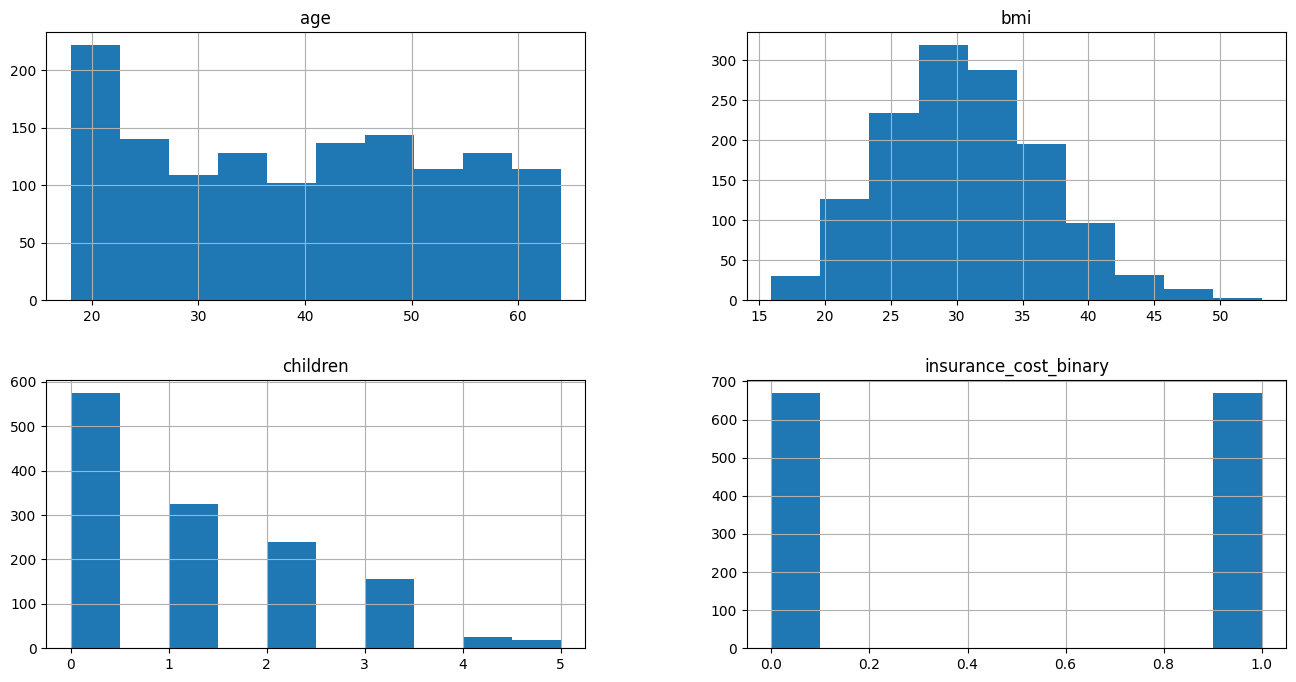

In [25]:
df.hist(bins=10, figsize=(16, 8))

<Axes: >

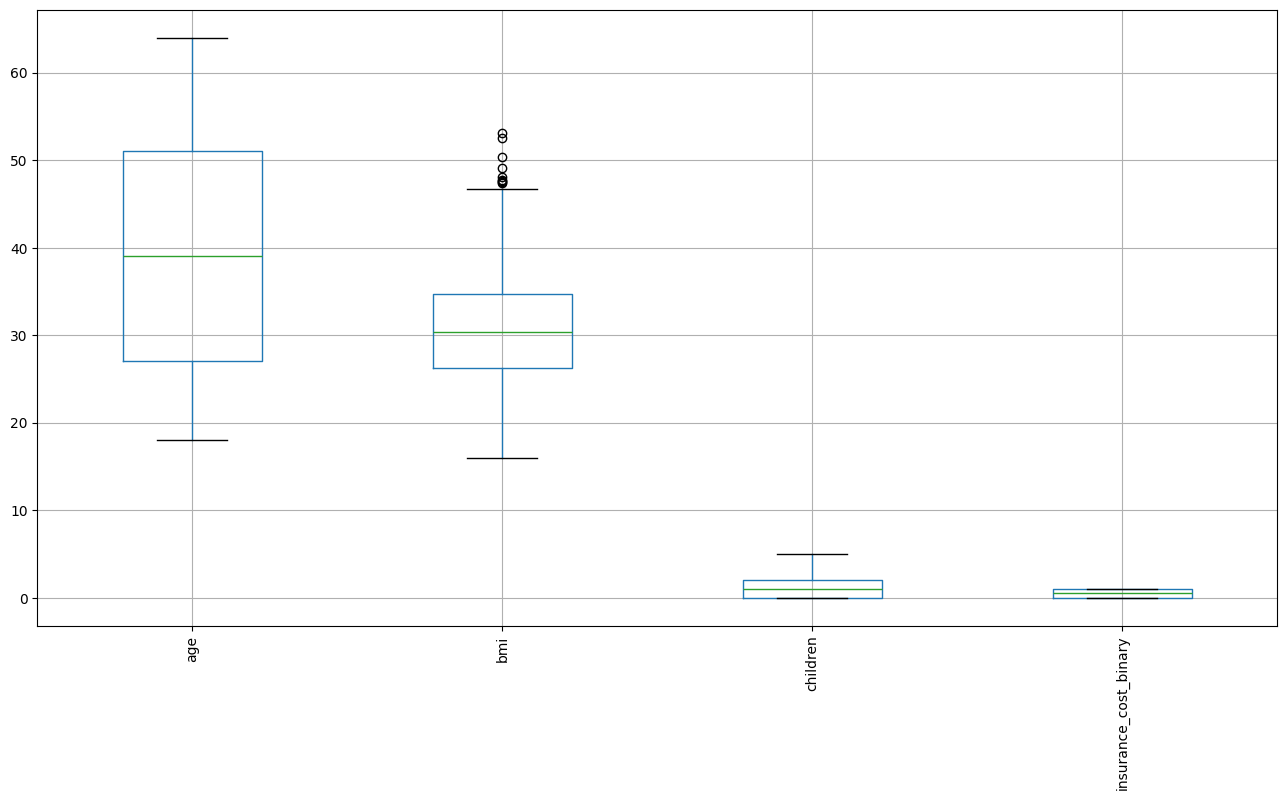

In [26]:
df.boxplot(figsize=(16, 8), rot=90)

### Define Preprocessing pipeline

In [27]:
# transformers
# Transform gender to binary values "male"=0, "female"=1
gender_transformer = FunctionTransformer(
    lambda x: np.where(x == 'male', 0, 1)
)

# Transform region to binary values "northeast"=0, "southeast"=1, "southwest"=2, "northwest"=3
region_transformer = FunctionTransformer(
    lambda x: pd.get_dummies(x, drop_first=True)
)

# Transform smoker to binary values "yes"=1, "no"=0
smoker_transformer = FunctionTransformer(
    lambda x: np.where(x == 'yes', 1, 0)
)

# Transform BMI using log transformation to reduce skewness and impact of outliers
bmi_transformer  = Pipeline(
    steps=[
        ("log_transform", FunctionTransformer(np.log)), 
        ("scaler", RobustScaler())
    ]
)

# Transform children using cubic root transformation to reduce skewness
children_transformer = Pipeline(
    steps = [
        ("cubic_root_transform", FunctionTransformer(np.cbrt)),
        ("scaler", RobustScaler())
    ]
)

# Define the preprocessor
preprocessor_pipeline = ColumnTransformer(
    transformers=[
        ('bmi', bmi_transformer, ['bmi']),
        ('age', StandardScaler(), ['age']),
        ('children', children_transformer, ['children']),
        ('gender', gender_transformer, ['gender']),
        ('region', region_transformer, ['region']),
        ('smoker', smoker_transformer, ['smoker'])
    ]
)

In [28]:
# Split the data into training and testing sets
X = df.drop(columns=['insurance_cost_binary'])
y = df['insurance_cost_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Define & Optimise Models

#### SVM Model

In [29]:
# create the pipeline for SVM
svm_pipe = Pipeline(steps=[
    ('preprocess', preprocessor_pipeline), 
    ('dimension_reduction', "passthrough"),
    ('svm', svm.SVC(probability=True))
])
set_config(display="diagram")
svm_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('bmi',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('age', StandardScaler(),
                                                  ['age']),
                                                 ('children',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['children']),
                                                 ('gender',
                                                  FunctionTransformer(func=<function <lambda> at 0x000002AD8E277560>),
                                                  ['gender']),
                                                 ('region',
                                                  FunctionTransformer(func=<function <lambda> at 0x000002AD8E2777E0>),
                                                  ['region']),
                                                 ('smoker',
                                                  FunctionTransformer(func=<function <lambda> at 0x000002AD8E277880>),
                                                  ['smoker'])])),
                ('dimension_reduction', 'passthrough'),
                ('svm', SVC(probability=True))])

In [30]:
# Use Bayesian optimization for hyperparameter tuning
# Define the parameter space for SVM
param_space_svm = [
    {
        'dimension_reduction': ["passthrough"],
        'svm__C': Real(1e-2, 1e+4, prior='log-uniform'),
        'svm__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
        'svm__kernel': Categorical(['linear', 'rbf', 'poly'])
    },
    {
        'dimension_reduction': [PCA()],
        'dimension_reduction__n_components': Integer(1, 5),
        'svm__C': Real(1e-2, 1e+4, prior='log-uniform'),
        'svm__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
        'svm__kernel': Categorical(['linear', 'rbf', 'poly'])
    },
    {
        'dimension_reduction': [RFE(RandomForestClassifier())],
        'svm__C': Real(1e-2, 1e+4, prior='log-uniform'),
        'svm__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
        'svm__kernel': Categorical(['linear', 'rbf', 'poly'])
    }
]

# Search for the best hyperparameters using Bayesian optimization
bayes_opt_svm = BayesSearchCV(
    svm_pipe, 
    param_space_svm, 
    n_iter=16, 
    cv=5, 
    n_jobs=-1, 
    random_state=42,
    refit=True
)
bayes_opt_svm.fit(X_train, y_train)

print("Best CV score = %0.3f:" % bayes_opt_svm.best_score_)
print("Best parameters: ", bayes_opt_svm.best_params_)

# store the best params and best model for later use
bayes_SVM_best_params = bayes_opt_svm.best_params_
bayes_SVM_best_model = bayes_opt_svm.best_estimator_

c:\Users\Brian\anaconda3\envs\ai_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('passthrough'), 10000.0, 10.0, np.str_('linear')] before, using random point ['passthrough', 4706.521495127359, 0.0007335928445838122, 'poly']
  warnings.warn(
c:\Users\Brian\anaconda3\envs\ai_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('passthrough'), 10000.0, 10.0, np.str_('linear')] before, using random point ['passthrough', 5235.462155093951, 0.021641704728236885, 'rbf']
  warnings.warn(


Best CV score = 0.928:
Best parameters:  OrderedDict({'dimension_reduction': 'passthrough', 'svm__C': 5235.462155093951, 'svm__gamma': 0.021641704728236885, 'svm__kernel': 'rbf'})


Without PCA dimensionality reduction results:
- Best CV score = 0.929:
- Best parameters:  OrderedDict({'svm__C': 10000.0, 'svm__gamma': 0.019487905798596106, 'svm__kernel': 'rbf'})

In [31]:
# Define the model
param_grid = [
    {
        'dimension_reduction': ["passthrough"],
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': [1, 0.1, 0.01, 0.001],
        'svm__kernel': ['rbf', 'linear', 'poly']
    },
    {
        'dimension_reduction': [PCA()],
        'dimension_reduction__n_components': [2, 3, 4, 5],
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': [1, 0.1, 0.01, 0.001],
        'svm__kernel': ['rbf', 'linear', 'poly']
    },
    {
        'dimension_reduction': [RFE(RandomForestClassifier())],
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': [1, 0.1, 0.01, 0.001],
        'svm__kernel': ['rbf', 'linear', 'poly']
    }
]

search_opt_svm = GridSearchCV(svm_pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search_opt_svm.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search_opt_svm.best_score_)
print("Best parameters: ", search_opt_svm.best_params_)

# store the best params and best model for later use
search_SVM_best_params = search_opt_svm.best_params_
search_SVM_best_model = search_opt_svm.best_estimator_

Best CV score = 0.932:
Best parameters:  {'dimension_reduction': 'passthrough', 'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}


#### Random Forest Model

In [32]:
# create the pipeline for Random Forest
random_forest_pipe = Pipeline(steps=[
    ('preprocess', preprocessor_pipeline),
    ('reduce_dim', 'passthrough'),
    ('random_forest', RandomForestClassifier())
])
random_forest_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('bmi',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('age', StandardScaler(),
                                                  ['age']),
                                                 ('children',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['children']),
                                                 ('gender',
                                                  FunctionTransformer(func=<function <lambda> at 0x000002AD8E277560>),
                                                  ['gender']),
                                                 ('region',
                                                  FunctionTransformer(func=<function <lambda> at 0x000002AD8E2777E0>),
                                                  ['region']),
                                                 ('smoker',
                                                  FunctionTransformer(func=<function <lambda> at 0x000002AD8E277880>),
                                                  ['smoker'])])),
                ('reduce_dim', 'passthrough'),
                ('random_forest', RandomForestClassifier())])

In [36]:
# Define parameter space for Random Forest
param_space_rf = {
    'reduce_dim': [None, 
                   PCA(), 
                   RFE(estimator=RandomForestClassifier())
                   ],
    'random_forest__n_estimators': Integer(50, 200),
    'random_forest__max_depth': Integer(1, 30),
    'random_forest__n_estimators': [50, 100, 200],
    'random_forest__max_depth': [None, 10, 20, 30],
    'random_forest__min_samples_split': [2, 5, 10],
    'random_forest__min_samples_leaf': [1, 2, 4]
}

# Search for the best hyperparameters using Bayesian optimization
bayes_opt_rf = BayesSearchCV(
    random_forest_pipe, 
    param_space_rf, 
    n_iter=16, 
    cv=5, 
    n_jobs=-1, 
    random_state=42,
    refit=True
)

bayes_opt_rf.fit(X_train, y_train)
print("Best CV score = %0.3f:" % bayes_opt_rf.best_score_)
print("Best parameters: ", bayes_opt_rf.best_params_)

# store the best params and best model for later use
bayes_RF_best_params = bayes_opt_rf.best_params_
bayes_RF_best_model = bayes_opt_rf.best_estimator_

Best CV score = 0.933:
Best parameters:  OrderedDict({'random_forest__max_depth': 20, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 5, 'random_forest__n_estimators': 50, 'reduce_dim': None})


In [37]:
# Define the model
N_FEATURES_OPTIONS = [2, 3, 4, 5]
param_grid = [
    {
        'reduce_dim': [None],
        'random_forest__n_estimators' : [10,20,30],
        'random_forest__max_depth': [2, 4, 6, 8],
        'random_forest__min_samples_split': [2, 4, 6],
        'random_forest__min_samples_leaf': [1, 2, 4],
    },
    {
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'random_forest__n_estimators' : [10,20,30],
        'random_forest__max_depth': [2, 4, 6, 8],
        'random_forest__min_samples_split': [2, 4, 6],
        'random_forest__min_samples_leaf': [1, 2, 4],
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(RandomForestClassifier(n_estimators=10))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'random_forest__n_estimators' : [10,20,30],
        'random_forest__max_depth': [2, 4, 6, 8],
        'random_forest__min_samples_split': [2, 4, 6],
        'random_forest__min_samples_leaf': [1, 2, 4],
    },
]
search = GridSearchCV(
    random_forest_pipe, 
    param_grid, 
    n_jobs=-1, 
    cv=5, 
    refit=True
)

# Fit the model
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
search_RF_best_params = search.best_params_
search_RF_best_model = search.best_estimator_

Best CV score = 0.936:
Best parameters:  {'random_forest__max_depth': 8, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 30, 'reduce_dim': None}


#### MLPClassifier Model

In [38]:
# Custom wrapper for MLPClassifier
class MLPClassifierWrapper(BaseEstimator, TransformerMixin):
    """Custom wrapper for MLPClassifier to allow for hyperparameter tuning."""

    def __init__(self, n_units=100, n_layers=1, activation='relu', solver='adam', alpha=1e-4, learning_rate='constant', learning_rate_init=0.001):
        """
        Initialize the MLPClassifierWrapper.
        Args:
            n_units (int): Number of units in each hidden layer.
            n_layers (int): Number of hidden layers.
            activation (str): Activation function for the hidden layers.
            solver (str): Solver for weight optimization.
            alpha (float): L2 penalty (regularization term) parameter.
            learning_rate (str): Learning rate schedule for weight updates.
            learning_rate_init (float): Initial learning rate used.
        
        Returns:
            None
        """
        self.n_units = n_units
        self.n_layers = n_layers
        self.activation = activation
        self.solver = solver
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.learning_rate_init = learning_rate_init

    def fit(self, X, y):
        """
        Fit the MLPClassifier to the training data.

        Args:
            X (array-like): Training data.
            y (array-like): Target values.

        Returns:
            self: Fitted estimator.
        """
        hidden_layers = tuple([self.n_units] * self.n_layers)
        self.model = MLPClassifier(
            hidden_layer_sizes=hidden_layers,
            activation=self.activation,
            solver=self.solver,
            alpha=self.alpha,
            learning_rate=self.learning_rate,
            learning_rate_init=self.learning_rate_init,
            max_iter=300,
            random_state=42
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        """
        Predict using the fitted MLPClassifier.

        Args:
            X (array-like): Input data.
        
        Returns:
            array: Predicted classes.
        """
        return self.model.predict(X)
    
    def predict_proba(self, X):
        """
        Predict class probabilities using the fitted MLPClassifier.

        Args:
            X (array-like): Input data.
        
        Returns:
            array: Predicted class probabilities.
        """
        return self.model.predict_proba(X)

    def score(self, X, y):
        """
        Score the MLPClassifier on the given data.

        Args:
            X (array-like): Input data.
            y (array-like): True labels for X.
        
        Returns:
            float: Mean accuracy of the model on the given data and labels.
        """
        return self.model.score(X, y)

In [48]:
# create the pipeline for MLPClassifier
mlp_pipe = Pipeline(steps=[
    ('preprocess', preprocessor_pipeline), 
    ('reduce_dim', 'passthrough'),
    ('mlp', MLPClassifierWrapper())
])
mlp_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('bmi',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('age', StandardScaler(),
                                                  ['age']),
                                                 ('children',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['children']),
                                                 ('gender',
                                                  FunctionTransformer(func=<function <lambda> at 0x000002AD8E277560>),
                                                  ['gender']),
                                                 ('region',
                                                  FunctionTransformer(func=<function <lambda> at 0x000002AD8E2777E0>),
                                                  ['region']),
                                                 ('smoker',
                                                  FunctionTransformer(func=<function <lambda> at 0x000002AD8E277880>),
                                                  ['smoker'])])),
                ('reduce_dim', 'passthrough'),
                ('mlp', MLPClassifierWrapper())])

In [51]:
# Use Bayesian optimization for hyperparameter tuning
param_space_mlp = {
    'reduce_dim': [None, PCA(), RFE(RandomForestClassifier()), RFE(svm.SVR(kernel='linear', gamma='auto'))],
    'mlp__n_units': Integer(50, 200),
    'mlp__n_layers': Integer(1, 3),
    'mlp__activation': Categorical(['relu', 'tanh', 'logistic']),
    'mlp__solver': Categorical(['adam', 'sgd']),
    'mlp__alpha': Real(1e-6, 1e-2, prior='log-uniform'),
    'mlp__learning_rate': Categorical(['constant', 'adaptive']),
    'mlp__learning_rate_init': Real(1e-4, 1e-1, prior='log-uniform'),
}

# Search for the best hyperparameters using Bayesian optimization
bayes_opt_mlp = BayesSearchCV(
    estimator=mlp_pipe,
    search_spaces=param_space_mlp,
    n_iter=14,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    refit=True,
)

bayes_opt_mlp.fit(X_train, y_train)

print("Best CV score = %0.3f:" % bayes_opt_mlp.best_score_)
print("Best parameters: ", bayes_opt_mlp.best_params_)

# store the best params and best model for later use
bayes_MLP_best_params = bayes_opt_mlp.best_params_
bayes_MLP_best_model = bayes_opt_mlp.best_estimator_

Best CV score = 0.936:
Best parameters:  OrderedDict({'mlp__activation': 'logistic', 'mlp__alpha': 0.0006345791205561904, 'mlp__learning_rate': 'adaptive', 'mlp__learning_rate_init': 0.0017679226616446444, 'mlp__n_layers': 2, 'mlp__n_units': 82, 'mlp__solver': 'adam', 'reduce_dim': PCA()})


c:\Users\Brian\anaconda3\envs\ai_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### Model Evaluation & Comparison
Compare the 5 models based on the following:
- Accuracy
- Precision
- Recall
- F1-Score
- TPR (True Positive Rate)
- AUC (Area under the ROC Curve)

In [41]:
mean_fpr = np.linspace(0, 1, 100)

In [52]:
# List models
models = [
    ('SVM Bayes', bayes_SVM_best_model),
    ('Random Forest Bayes', bayes_RF_best_model),
    ('MLP Bayes', bayes_MLP_best_model),
    ('SVM Grid Search', search_SVM_best_model),
    ('Random Forest Grid Search', search_RF_best_model)
]

In [43]:
def evaluate_model(model, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    # Compute true positive rate for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, fpr, tpr)])

    roc_auc = auc(fpr, tpr)

    return accuracy, precision, recall, f1, _tpr_transformed, roc_auc


c:\Users\Brian\anaconda3\envs\ai_env\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\Brian\anaconda3\envs\ai_env\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


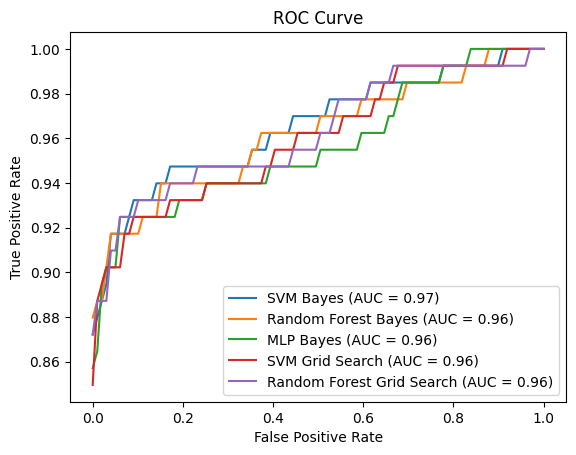

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,SVM Bayes,0.929104,0.959677,0.894737,0.926070,0.965302
1,Random Forest Grid Search,0.936567,0.983333,0.887218,0.932806,0.962517
2,Random Forest Bayes,0.936567,0.967742,0.902256,0.933852,0.961849
3,SVM Grid Search,0.925373,0.931298,0.917293,0.924242,0.959733
4,MLP Bayes,0.936567,0.967742,0.902256,0.933852,0.956502


In [59]:
table = pd.DataFrame()

# Evaluate each model and store the results in the table
for model_name, model in models:
    accuracy, precision, recall, f1, tpr_transformed, roc_auc = evaluate_model(model, X_test, y_test)
    table = pd.concat([table, pd.DataFrame([{
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
    }])], ignore_index=True)

    # Plot ROC curve
    plt.plot(mean_fpr, tpr_transformed[0], label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
plt.show()

# Display the results table
table.sort_values(by='ROC AUC', ascending=False, inplace=True)
table.reset_index(drop=True, inplace=True)
table.head()

From the results we can see that we have 5 promising models with similar results. The metrics produce show that there is a some variations in the performance of the models. Random Forest Bayes and MLP Bayes stand out as the top performers overall. They both achieve high similar accuracy and a share the same strong F1 score. This precision and recall for these models are also solid, suggesting they are reliably identifying positive cases while keeping false positives relatively low. The ROC AUC score is lower than some other models, they both still scored high, indicating strong overall discriminative ability.

Utilizing either of these models in the real world to determine if the persons insurance cost is above the median based on their age, gender, BMI, number of children, smoker status, and region would be achievable. The high F1 score indicates the models would be well suited to making reliable, balanced predictions. High recall scores indicate the models would be effective at identifying individuals likely to incur higher insurance costs. For example this maybe useful for insurance companies looking to minimise risk.

# Conclusion